# 230. mnist dataset 손글씨 인식 - LeNet

- CNN 을 이용한 mnist dataset 손글씨 인식  
- Yan LeCunn 이 1998 년 발표한 LeNet-5 을 Pytorch 로 customize 하여 재현

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
from torch.utils.data.sampler import SubsetRandomSampler

In [24]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

transforms.ToTensor()의 주요 특징:

1) 데이터 타입 변환: PIL 이미지나 NumPy ndarray를 torch.FloatTensor로 변환  
2) 스케일링: 이미지의 픽셀 값 범위를 [0, 255]에서 [0.0, 1.0]으로 스케일링  
3) 차원 재배열: PyTorch에서는 이미지 데이터를 [C, H, W] 형식(채널, 높이, 너비)으로 처리하므로 입력 이미지 데이터의 차원을 이 형식으로 자동으로 재배열

In [25]:
# transforms.Compose는 여러 변환(transform)을 함께 결합할 때 사용됩니다.
composed = transforms.Compose([
    transforms.ToTensor(),  # 이미지를 PyTorch 텐서로 변환하고 [0.0, 1.0]으로 스케일링
    # 정규화를 수행합니다. 평균(mean)은 0.1, 표준편차(std)는 0.3으로 설정
    # 이 경우는 단일 채널(예: 흑백 이미지)의 이미지를 가정
    transforms.Normalize((0.1,), (0.3,))
])

In [26]:
train_data = dsets.MNIST(root='./data', train=True, download=True, transform=composed)

test_data = dsets.MNIST(root='./data', train=False, download=True, transform=composed)

In [28]:
print(train_data)
print()
print(test_data)

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.1,), std=(0.3,))
           )

Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.1,), std=(0.3,))
           )


- Data 시각화

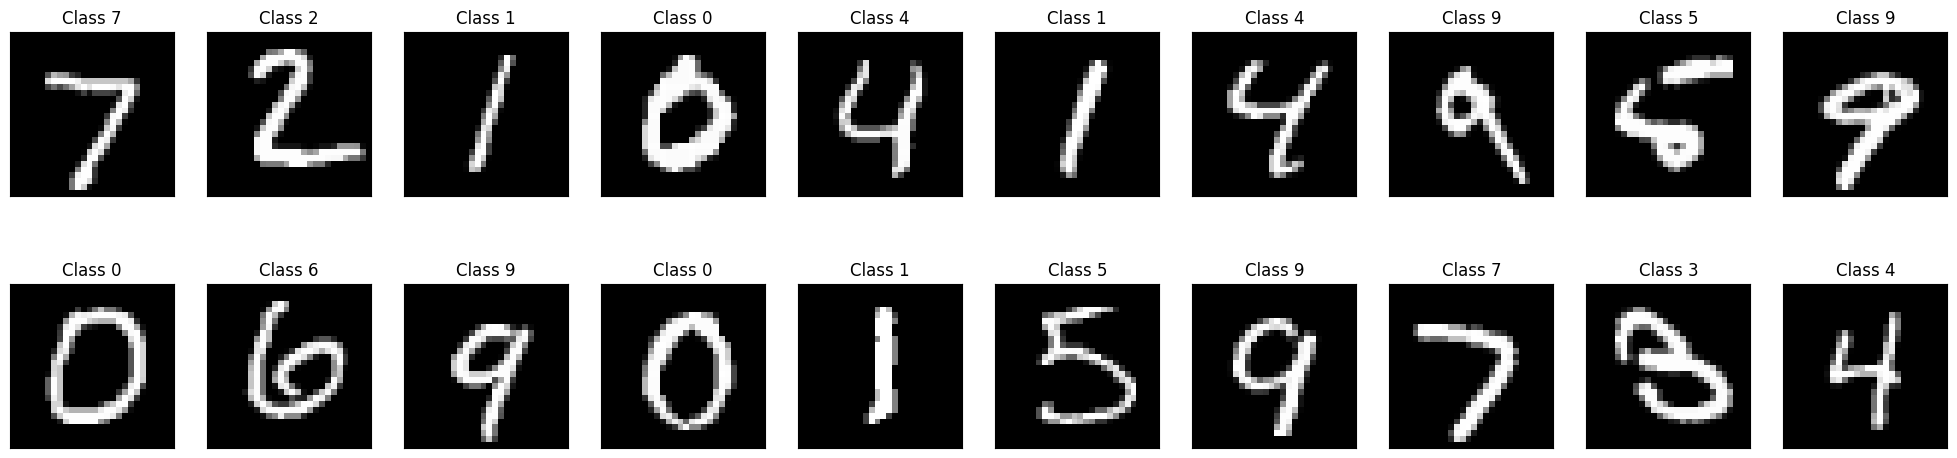

In [30]:
plt.figure(figsize=(25, 6))
for i, (x, y) in enumerate(test_data):
    if i > 19:
        break
    plt.subplot(2, 10, i+1)
    plt.imshow(x.numpy().reshape(28, 28), cmap='gray')
    plt.title("Class {}".format(y))
    plt.xticks([])
    plt.yticks([])

plt.show()

### Dataset Loader 생성
- Train dataset 을 Train 와 Validation 으로 분리

In [31]:
# 전체 훈련 데이터의 20%를 검증 데이터로 설정
valid_size = 0.2

# 훈련 데이터셋의 총 길이
num_train = len(train_data)

# 0부터 num_train-1까지의 인덱스 생성
indices = list(range(num_train))

# 인덱스를 무작위로 섞습니다. 이를 통해 데이터셋의 무작위성을 보장합니다.
np.random.shuffle(indices)

# 검증 세트의 크기에 해당하는 분할 지점 계산
split = int(np.floor(valid_size * num_train))

# 계산된 분할 지점을 기준으로 훈련 세트와 검증 세트의 인덱스를 나눕니다.
# split 이후의 인덱스는 훈련 세트, split 이전의 인덱스는 검증 세트로 사용됩니다.
train_idx, valid_idx = indices[split:], indices[:split]

# 훈련 세트와 검증 세트의 인덱스를 사용하여 SubsetRandomSampler 객체를 생성합니다.
# 이 샘플러는 DataLoader에 전달될 때, 지정된 인덱스에 해당하는 데이터만을 무작위로 추출하는 데 사용됩니다.
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

- train, validation, test dataset 으로 3 분할

In [32]:
batch_size = 128

# 데이터 로더를 생성합니다. 이 DataLoader는 앞서 정의한 train_sampler를 사용하여
# 지정된 인덱스에 따라 훈련 데이터셋에서 무작위로 데이터를 샘플링합니다.
# 이렇게 함으로써 훈련 과정에서의 데이터 다양성을 증가시킬 수 있습니다.
train_loader = torch.utils.data.DataLoader(dataset=train_data,
                                           batch_size=batch_size, sampler=train_sampler)

valid_loader = torch.utils.data.DataLoader(dataset=train_data,
                                           batch_size=batch_size, sampler=valid_sampler)

test_loader  = torch.utils.data.DataLoader(dataset=test_data,
                                           batch_size=batch_size, shuffle=False)

## Model build

<img src="https://d2l.ai/_images/lenet.svg" width="800" />

In [33]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, padding=2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        self.maxpool = nn.MaxPool2d(2)  #pool size = 2
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.maxpool(x)
        x = self.relu(self.conv2(x))
        x = self.maxpool(x)
#         print(x.shape)
#         return
        x = torch.flatten(x, 1)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        out = self.fc3(x)
        return out

In [34]:
model = LeNet()
model

LeNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
)

In [35]:
# 'train_loader'에서 첫 번째 배치를 가져옵니다.
# 'iter()' 함수를 사용하여 반복 가능한 객체에서 반복자(iterator)를 생성하고,
# 'next()' 함수를 사용하여 첫 번째 요소(배치)를 추출합니다.
# 이 때, [0]은 첫 번째 배치의 데이터(특성) 부분을 의미합니다.
# 배치의 두 번째 요소는 레이블(label)이 될 것입니다.
first_batch_data = next(iter(train_loader))[0]

# 출력된 형태는 [배치 크기, 채널 수, 높이, 너비] 형태를 갖습니다.
print(first_batch_data.shape)

torch.Size([128, 1, 28, 28])


In [36]:
# 모델에 첫 번째 배치의 데이터를 전달하여 순방향(forward) 연산을 수행합니다.
# 'train_loader'에서 첫 번째 배치를 가져오기 위해 iter()와 next() 함수를 사용합니다.
# next(iter(train_loader))[0]는 첫 번째 배치의 데이터 부분을 의미하며,
# 이 데이터는 모델의 입력으로 사용됩니다.

# 모델의 forward 메서드를 호출하여 첫 번째 배치 데이터에 대한 예측을 수행합니다.
# 분류 문제의 경우 출력은 각 클래스에 속할 확률을 나타낼 수 있습니다.
model.forward(next(iter(train_loader))[0])

tensor([[-3.8035e-02, -6.3702e-06, -2.9545e-02,  ...,  3.0304e-02,
         -7.5397e-02,  9.7670e-02],
        [-6.4253e-02, -7.4797e-03, -4.2045e-02,  ...,  1.3926e-02,
         -5.1858e-02,  1.0130e-01],
        [-6.1837e-02, -5.7431e-03, -4.6678e-02,  ...,  1.6100e-02,
         -4.7075e-02,  1.0594e-01],
        ...,
        [-7.4064e-02, -2.0877e-02, -4.3102e-02,  ...,  3.4052e-02,
         -5.4244e-02,  9.3796e-02],
        [-7.7927e-02, -3.0509e-03, -3.7655e-02,  ...,  1.6997e-02,
         -3.3618e-02,  1.0309e-01],
        [-6.4087e-02,  9.7116e-03, -2.8442e-02,  ...,  2.1576e-02,
         -4.6705e-02,  1.0427e-01]], grad_fn=<AddmmBackward0>)

### Model Summary

In [37]:
for k, v in model.state_dict().items():
    print(k, v.numel())

print("Total parameters :", sum(p.numel() for p in model.parameters()))

conv1.weight 150
conv1.bias 6
conv2.weight 2400
conv2.bias 16
fc1.weight 48000
fc1.bias 120
fc2.weight 10080
fc2.bias 84
fc3.weight 840
fc3.bias 10
Total parameters : 61706


### Loss Function

In [38]:
criterion = nn.CrossEntropyLoss()

model.to(device)

LeNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
)

In [39]:
lr = 0.01
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

In [40]:
LOSS, VAL_LOSS, ACC, VAL_ACC = [], [], [], []
EPOCHS = 10  # 총 에폭 수 설정

for epoch in range(EPOCHS):

    model.train()  # 모델을 훈련 모드로 설정

    train_loss = 0  # 훈련 손실을 누적할 변수 초기화
    train_acc = 0   # 훈련 정확도를 누적할 변수 초기화
    for x, y in train_loader:  # 훈련 데이터셋을 배치 단위로 불러옴
        x, y = x.to(device), y.to(device)  # 데이터를 현재 디바이스(CPU 또는 GPU)로 이동

        optimizer.zero_grad()  # 옵티마이저의 그라디언트 초기화

        z = model(x)  # 모델을 통해 예측값(z) 계산
        loss = criterion(z, y)  # 손실 함수를 통해 손실 계산
        train_loss += loss.item()  # 배치 손실을 누적
        _, y_pred = torch.max(z, 1)  # 예측값 중 가장 높은 값을 가진 인덱스 추출
        train_acc += (y_pred == y).sum().item()  # 정확한 예측 수 누적

        loss.backward()  # 손실에 대한 그라디언트 계산(역전파)
        optimizer.step()  # 모델의 가중치 업데이트

    train_loss /= len(train_sampler)  # 평균 훈련 손실 계산
    train_acc /= len(train_sampler)   # 평균 훈련 정확도 계산
    LOSS.append(train_loss)
    ACC.append(train_acc)

    model.eval()   # 모델을 평가 모드로 설정

    val_loss = 0  # 검증 손실을 누적할 변수 초기화
    val_acc = 0   # 검증 정확도를 누적할 변수 초기화
    for x, y in valid_loader:  # 검증 데이터셋을 배치 단위로 불러옴
        x, y = x.to(device), y.to(device)

        z = model(x)
        loss = criterion(z, y)
        val_loss += loss.item()
        _, y_pred = torch.max(z, 1)
        val_acc += (y_pred == y).sum().item()

    val_loss /= len(valid_sampler)  # 평균 검증 손실 계산
    val_acc  /= len(valid_sampler)  # 평균 검증 정확도 계산
    VAL_LOSS.append(val_loss)
    VAL_ACC.append(val_acc)

    # 에폭별 훈련 및 검증 결과 출력
    print(f'epoch {epoch} ==> train loss: {train_loss:.5f},  validation loss: {val_loss:.5f}',
                                            f'train acc: {train_acc:.5f}, validation acc: {val_acc:.5f}')

epoch 0 ==> train loss: 0.01667,  validation loss: 0.00918 train acc: 0.31408, validation acc: 0.71250
epoch 1 ==> train loss: 0.00422,  validation loss: 0.00246 train acc: 0.84171, validation acc: 0.90717
epoch 2 ==> train loss: 0.00213,  validation loss: 0.00183 train acc: 0.91800, validation acc: 0.92392
epoch 3 ==> train loss: 0.00153,  validation loss: 0.00134 train acc: 0.94248, validation acc: 0.94658
epoch 4 ==> train loss: 0.00120,  validation loss: 0.00106 train acc: 0.95492, validation acc: 0.95883
epoch 5 ==> train loss: 0.00100,  validation loss: 0.00124 train acc: 0.96192, validation acc: 0.94917
epoch 6 ==> train loss: 0.00088,  validation loss: 0.00085 train acc: 0.96683, validation acc: 0.96625
epoch 7 ==> train loss: 0.00077,  validation loss: 0.00075 train acc: 0.97050, validation acc: 0.97050
epoch 8 ==> train loss: 0.00070,  validation loss: 0.00072 train acc: 0.97388, validation acc: 0.97167
epoch 9 ==> train loss: 0.00065,  validation loss: 0.00065 train acc: 0.9

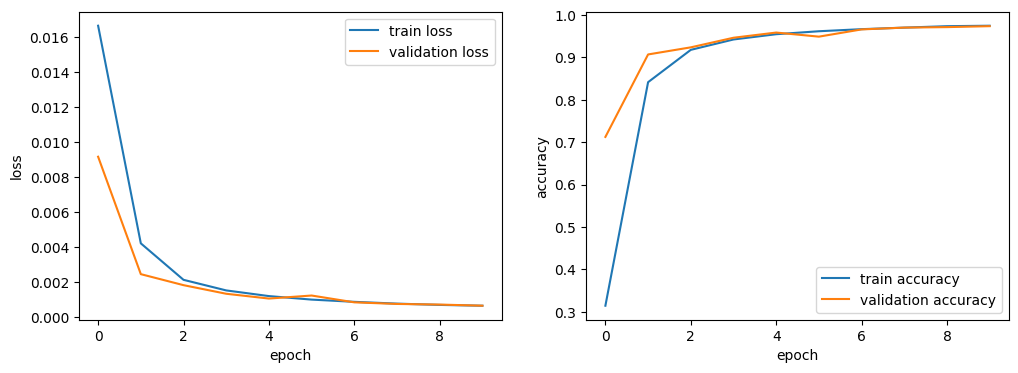

In [41]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.plot(LOSS, label='train loss')
ax1.plot(VAL_LOSS, label='validation loss')
ax1.set_xlabel('epoch')
ax1.set_ylabel('loss')
ax1.legend()
ax2.plot(ACC, label='train accuracy')
ax2.plot(VAL_ACC, label='validation accuracy')
ax2.set_xlabel('epoch')
ax2.set_ylabel('accuracy')
ax2.legend()

## Model 평가 - Test set 사용

In [42]:
predictions = []  # 모델의 예측을 저장할 리스트
labels = []  # 실제 레이블을 저장할 리스트

model.eval()  # 모델을 평가 모드로 설정

# 테스트 로더를 통해 테스트 데이터셋의 배치를 순회
for x, y in test_loader:
    x, y = x.to(device), y.to(device)  # 데이터를 현재 디바이스(CPU 또는 GPU)로 이동
    z = model(x)  # 모델에 데이터를 전달하여 예측값(z) 계산
    _, y_pred = torch.max(z, 1)  # 예측값 중 가장 높은 값을 가진 인덱스 추출

    # 예측 결과와 실제 레이블을 CPU로 이동 후 numpy 배열로 변환하여 리스트에 추가
    predictions.extend(y_pred.cpu().numpy())
    labels.extend(y.cpu().numpy())

# 예측값과 실제 레이블이 일치하는 인덱스 추출
correct_indices = np.nonzero(np.array(predictions) == np.array(labels))[0]
# 예측값과 실제 레이블이 일치하지 않는 인덱스 추출
incorrect_indices = np.nonzero(np.array(predictions) != np.array(labels))[0]

# 정확도 계산: 정확한 예측의 수를 전체 예측의 수로 나눈 후 백분율로 변환
print("accuracy = {:.2f}%".format(len(correct_indices) / len(predictions) * 100))

accuracy = 97.77%


## Category 별 분류 성능 측정

accuracy of 0 = 98.98%
accuracy of 1 = 99.47%
accuracy of 2 = 97.48%
accuracy of 3 = 96.73%
accuracy of 4 = 99.08%
accuracy of 5 = 97.42%
accuracy of 6 = 98.75%
accuracy of 7 = 97.18%
accuracy of 8 = 97.13%
accuracy of 9 = 95.34%


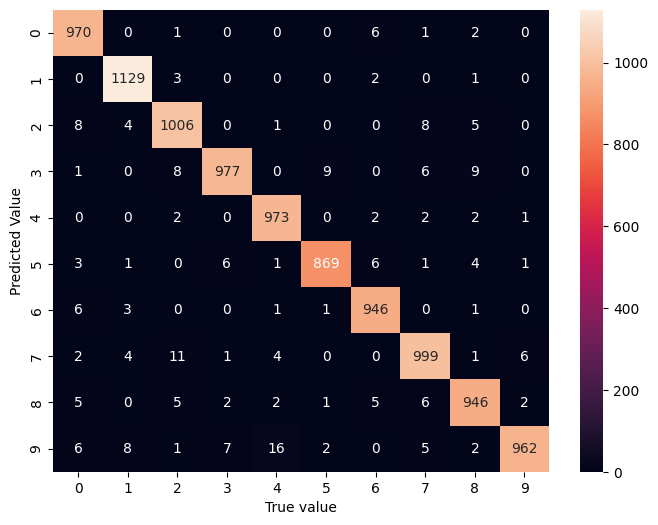

In [43]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(labels, predictions)
plt.figure(figsize=(8, 6))
ax = sns.heatmap(cm, annot=True, fmt='d')
ax.set_xlabel('True value')
ax.set_ylabel('Predicted Value')

for i in range(10):
    print(f"accuracy of {i} = {cm[i][i] / cm[i].sum() * 100:.2f}%")

# 실습 : fashion MNIST 를 이용하여 위와 동일한 작업

Label	Class

0	T-shirt/top  
1	Trouser  
2	Pullover  
3	Dress  
4	Coat  
5	Sandal  
6	Shirt  
7	Sneaker  
8	Bag  
9	Ankle boot

In [ ]:
composed = transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Normalize((0.1,), (0.3,))])

In [ ]:
# load mnist data
train_data = dsets.FashionMNIST(root='./data', train=True, download=True, transform=composed)

test_data = dsets.FashionMNIST(root='./data', train=False, download=True, transform=composed)

In [ ]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress',
               'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [ ]:
plt.figure(figsize=(25, 6))
for i, (x, y) in enumerate(test_data):
    if i > 19:
        break
    plt.subplot(2, 10, i+1)
    plt.imshow(x.numpy().reshape(28, 28), cmap='gray')
    plt.title(class_names[y])
    plt.xticks([])
    plt.yticks([])

plt.show()

In [ ]:
# Your code here